In [3]:
from requests import get
from bs4 import BeautifulSoup
from time import sleep
import re
from random import randint
from warnings import warn
from time import time
import numpy as np
import pandas as pd
#build out the loop

BASE_URL = "https://{region}.craigslist.org/search/apa?" #get rid of those lame-o's that post a housing option without a pic using their filter
REGION = "vancouver"
TARGET_URL = BASE_URL.format(region=REGION)

#get the first page of the east bay housing prices
response = get(TARGET_URL) 
html_soup = BeautifulSoup(response.text, 'html.parser')

#find the total number of posts to find the limit of the pagination
results_num = html_soup.find('div', class_= 'search-legend')
results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array

#each page has 119 posts so each new page is defined as follows: s=120, s=240, s=360, and so on. So we need to step in size 120 in the np.arange function
pages = np.arange(0, results_total+1, 120)

iterations = 0

post_timing = []
post_hoods = []
post_title_texts = []
bedroom_counts = []
sqfts = []
post_links = []
post_prices = []

for page in pages:
    
    #get request
    response = get(BASE_URL.format(region=REGION) 
                   + "s=" #the parameter for defining the page number 
                   + str(page) #the page number in the pages array from earlier
                   + "&hasPic=1"
                   + "&availabilityMode=0")

    sleep(randint(1,5))
     
    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
        
    #define the html text
    page_html = BeautifulSoup(response.text, 'html.parser')
    
    #define the posts
    posts = page_html.find_all('li', class_= 'result-row')
        
    #extract data item-wise
    for post in posts:

        if post.find('span', class_ = 'result-hood') is not None:

            #posting date
            #grab the datetime element 0 for date and 1 for time
            post_datetime = post.find('time', class_= 'result-date')['datetime']
            post_timing.append(post_datetime)

            #neighborhoods
            post_hood = post.find('span', class_= 'result-hood').text
            post_hoods.append(post_hood)

            #title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_title_texts.append(post_title_text)

            #post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            #removes the \n whitespace from each side, removes the currency symbol, and turns it into an int
            # print("PRICE:", post.a.text.strip().replace("$", "").replace(",", ""))
            post_price = int(post.a.text.strip().replace("$", "").replace(",", "")) 
            post_prices.append(post_price)
            
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                bedroom_counts.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            #    bedroom_counts.append(bedroom_count)
                
            #    sqft = np.nan
            #    sqfts.append(sqft)
                
    iterations += 1
    print("Page " + str(iterations) + " scraped successfully!")

print("\n")

print("Scrape complete!")

Page 1 scraped successfully!
Page 2 scraped successfully!
Page 3 scraped successfully!
Page 4 scraped successfully!
Page 5 scraped successfully!
Page 6 scraped successfully!
Page 7 scraped successfully!
Page 8 scraped successfully!
Page 9 scraped successfully!
Page 10 scraped successfully!
Page 11 scraped successfully!
Page 12 scraped successfully!
Page 13 scraped successfully!
Page 14 scraped successfully!
Page 15 scraped successfully!
Page 16 scraped successfully!
Page 17 scraped successfully!
Page 18 scraped successfully!
Page 19 scraped successfully!
Page 20 scraped successfully!
Page 21 scraped successfully!
Page 22 scraped successfully!
Page 23 scraped successfully!
Page 24 scraped successfully!
Page 25 scraped successfully!
Page 26 scraped successfully!


Scrape complete!


In [4]:


van_apts = pd.DataFrame({'posted': post_timing,
                       'neighborhood': post_hoods,
                       'post title': post_title_texts,
                       'number bedrooms': bedroom_counts,
                        'sqft': sqfts,
                        'URL': post_links,
                       'price': post_prices})
print(van_apts.info())
van_apts.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   posted           3000 non-null   object 
 1   neighborhood     3000 non-null   object 
 2   post title       3000 non-null   object 
 3   number bedrooms  2863 non-null   object 
 4   sqft             2573 non-null   float64
 5   URL              3000 non-null   object 
 6   price            3000 non-null   int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 164.2+ KB
None


,posted,neighborhood,post title,number bedrooms,sqft,URL,price
0,2022-04-08 13:42,(Vancouver Downtown),HOWE 1212 - 15th Floor 1 Bedroom Fully Furnished,1,550.0,https://vancouver.craigslist.org/van/apa/d/van...,2300
1,2022-04-08 13:41,(Crescent Beach Ocean Park),Semi-Detached 4 BR/3.5BA Townhouse - Furnished...,4,2591.0,https://vancouver.craigslist.org/rds/apa/d/sur...,4800
2,2022-04-08 13:41,(Beach District),Fully Furnished 1 BR condo w/City View @ Vanco...,1,598.0,https://vancouver.craigslist.org/van/apa/d/van...,3200
3,2022-04-08 13:41,(Coal Harbour),Over 2600 SF 2 Level Condo @ Two Harbour Green...,2,2600.0,https://vancouver.craigslist.org/van/apa/d/van...,7995
4,2022-04-08 13:40,(108 an 107a Ave Surrey),Short term or Long term Suite for single or Fa...,1,NaN,https://vancouver.craigslist.org/rds/apa/d/sur...,1700
5,2022-04-08 13:40,(North burnaby),Brand New 1 bedroom suite North Burnaby,1,500.0,https://vancouver.craigslist.org/bnc/apa/d/bur...,1800
6,2022-04-08 13:37,"(7428 14th Avenue, Burnaby)",Luxurious 2 bedroom Townhouse Available May 1 ...,2,1015.0,https://vancouver.craigslist.org/bnc/apa/d/bur...,2350
7,2022-04-08 13:36,"(Riverdale, Richmond)","Richmond house (Furnished if needed) for rent,...",5,NaN,https://vancouver.craigslist.org/rch/apa/d/ric...,5000
8,2022-04-08 13:36,(Vancouver Downtown),Vancouver Downtown 2BR with best location,2,900.0,https://vancouver.craigslist.org/van/apa/d/van...,4200
9,2022-04-08 13:34,(New Westminster),"1 Bedroom - TOP floor, View, Cat friendly (12t...",1,650.0,https://vancouver.craigslist.org/bnc/apa/d/bur...,1700


In [11]:
# Clean the data.
# remove prices listed at 0
van_apts = van_apts[(van_apts['price'] > 0)]

#first things first, drop duplicate URLs and Titles.
van_apts = van_apts.drop_duplicates(subset='post title')
print("Unique Posts:",van_apts.shape[0])

#make the number bedrooms to a float (since np.nan is a float too)
van_apts['number bedrooms'] = van_apts['number bedrooms'].apply(lambda x: float(x))

#convert datetime string into datetime object to be able to work with it
from datetime import datetime

van_apts['posted'] = pd.to_datetime(van_apts['posted'])

#Looking at what neighborhoods there are with van_apts['neighborhood'].unique() allowed me to see what
#I needed to deal with in terms of cleaning those.

#remove the parenthesis from the left and right of the neighborhoods
van_apts['neighborhood'] = van_apts['neighborhood'].map(lambda x: x.replace("(", ""))
van_apts['neighborhood'] = van_apts['neighborhood'].map(lambda x: x.replace(")", ""))

#titlecase them
van_apts['neighborhood'] = van_apts['neighborhood'].str.title()

#just take the first name of the neighborhood list, splitting on the '/' delimiter
van_apts['neighborhood'] = van_apts['neighborhood'].apply(lambda x: x.split('/')[0])

# #fix one-offs that
# van_apts['neighborhood'].replace('Belmont, Ca', 'Belmont', inplace=True)
# van_apts['neighborhood'].replace('Hercules, Pinole, San Pablo, El Sob', 'Hercules', inplace=True)

#remove whitespaces
van_apts['neighborhood'] = van_apts['neighborhood'].apply(lambda x: x.strip())




Unique Posts: 2744


Exploring Neighborhood descriptions

In [20]:
unique_neighborhoods = np.unique(van_apts['neighborhood'])
print("unique_neighborhoods", unique_neighborhoods[:10])

print("Rows:", van_apts.shape[0])
print("Shape", van_apts.shape)


unique_neighborhoods ['( Burnaby' '( City Of Vancouver' '( Delta' '( North Shore' '( Richmond'
 '( Tricities' '(#203 20696 Eastleigh Cres Delta'
 '(#507 20696 Eastleigh Cres Delta' '((Maple Ridge) Tricities'
 '(1001-7979 Firbridge Way, Richmond Richmond']
Rows: 2693
Shape (2693, 8)


In [7]:
# Compile List of Neighborhood/City Locations/keywords to help create neighborhood_keywords list
neighborhood_keyword_counts = {}
unwanted_specialchr = [',', '.', '"', '\'', ':', '!']
for area_str in van_apts['neighborhood']:
    working_str = area_str.replace(",", "")
    re.sub(f'[{"".join(unwanted_specialchr)}]', '', working_str)
    neighborhood_keywords = working_str.split()
    for word in neighborhood_keywords:
        try:
            neighborhood_keyword_counts[word] += 1
        except KeyError as e:
            neighborhood_keyword_counts[word] = 1

neighborhood_keyword_counts_list = sorted(list(neighborhood_keyword_counts.items()), key=lambda x: -x[1])
    
# print("neighborhood_keyword_counts_list", neighborhood_keyword_counts_list)

In [13]:
# Simplify Craigslist Neighborhood descriptions and add as new column
neighborhood_keywords = ['Vancouver', 'Burnaby', 'Coquitlam', 'Surrey', 'Richmond',
                         'New Westminster', 'Port Moody', 'Maple Ridge', 'Langley',
                         'Delta', 'North Vancouver', 'West Vancouver']
neighborhood_simplified = []
for area_str in van_apts['neighborhood']:
    area_str.replace(',', '')

    try:
        temp = re.findall(r"(?=("+'|'.join(neighborhood_keywords)+r"))", area_str)[0] 
    except IndexError as e:
        temp = ""
    neighborhood_simplified.append(temp)
# print("neighborhood_simplified", neighborhood_simplified)

van_apts["neighborhood_simplified"] = neighborhood_simplified
# print("van_apts", van_apts)
# print("type", type(van_apts))


In [14]:
#save the clean data to a .csv file
now = datetime.now()
datetime_str = now.strftime("%d-%m-%Y_%H-%M-%S")
van_apts.to_csv(f'van_apts_{datetime_str}.csv', index=False)

In [18]:
# Optionally load data from .csv
# van_apts = pd.read_csv('van_apts_Mar_2_22_clean.csv')
van_apts = pd.read_csv('van_apts_15-03-2022_16-06-39.csv')
print("Data Loaded from CSV")

Data Loaded from CSV


Now that we have our data in a cleaned and organized, it's time for some data exploration! To do so, lets visualize our data using matplotlib and seaborn.

I was initially curious about the distribution of our data, so I created a barplot to see the frequencies of craigslist postings for each neighborhood/region of the Lower Mainland that we've included when cleaning out neighboorhood data.

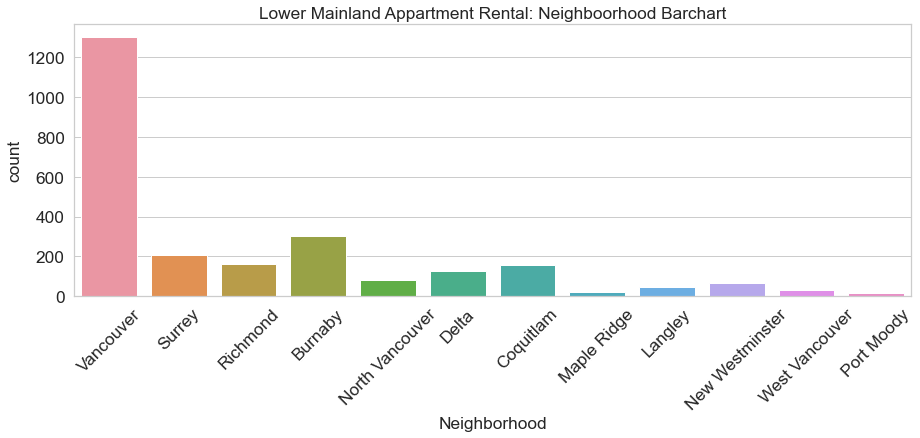

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns



sns.set_theme(style="whitegrid")
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

ax = sns.countplot(x="neighborhood_simplified", data=van_apts)
ax.set_xlabel("Neighborhood")
ax.set_title("Lower Mainland Appartment Rental: Neighboorhood Barchart")
plt.xticks(rotation=45)
plt.show()



Non-surprisingly, most of our craigslist postings advertised for Vancouver, the heart of the Lower Mainland, with a notable amount of postings from Burnaby and Surrey. At the back of the pack, we had minimal postings advertising for rental housing/apartments for Port Moody and Maple Ridge.

Whening trying to visualize our data for each neighboorhood with a boxplot, the plot had become "squished" as a result of what I thought had been an outlier. Using the describe() method on our dataframe, we get useful statitics on our dataset as a whole in addition to seeing that the outlier listing was advertising for $1.560888e+06 or $1,560,888! One statistic that grabbed my attention was the mean advertised rental price in our dataset for $3,514.86 / month! Stay strong fellow Vancouverites!


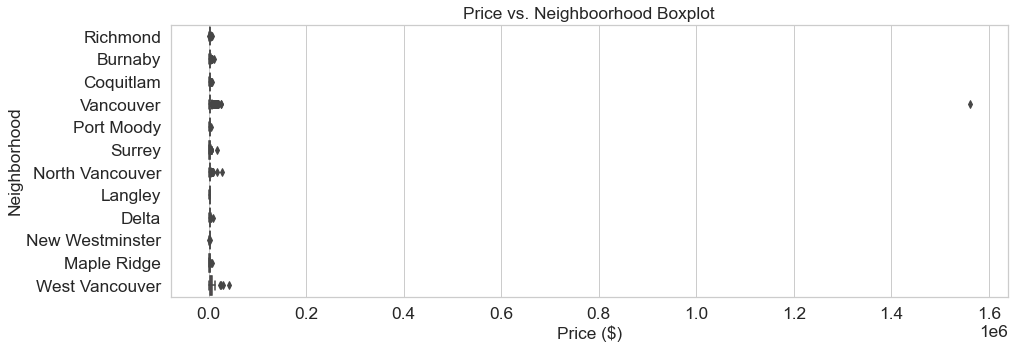

,number bedrooms,sqft,price
count,2622.000000,2372.000000,2.752000e+03
mean,1.929443,1019.779089,3.514865e+03
std,0.985578,794.001780,2.982038e+04
min,1.000000,1.000000,1.000000e+00
25%,1.000000,624.000000,1.800000e+03
50%,2.000000,806.000000,2.400000e+03
75%,2.000000,1100.000000,3.100000e+03
max,8.000000,16245.000000,1.560888e+06


In [13]:
# Box plot
ax = sns.boxplot(x='price', y='neighborhood_simplified', 
                 data=van_apts, orient='h')
ax.set_title("Price vs. Neighboorhood Boxplot")
ax.set_ylabel("Neighborhood")
ax.set_xlabel("Price ($)")
plt.show()

van_apts.describe()


Anyways, lets get rid of the outlier and plot a new boxplot. We do this by removing all rows whose price is greater or equal than the price at the 99th percentile of our dataset. I decided to do it this way because I wanted this outlier removal to be adaptable, instead of having to fish out every extremely large data point manually for every new dataset we analyze. Though this can introduce bias into the data, I am not really concerned about it for this project. Though we should take note and move on. 

If you need a refresher on how to interpret a boxplot (like I did), see the following diagram.
https://miro.medium.com/max/1400/1*2c21SkzJMf3frPXPAR_gZA.png
Interpreting a boxplot.

One thing to note is that Vancouver seems to have many more outlier datapoints compared to any other neighborhood, but we can assume that this is due to the vast amount of Vancouver data points in comparison to other neighboorhoods (see above bar chart).

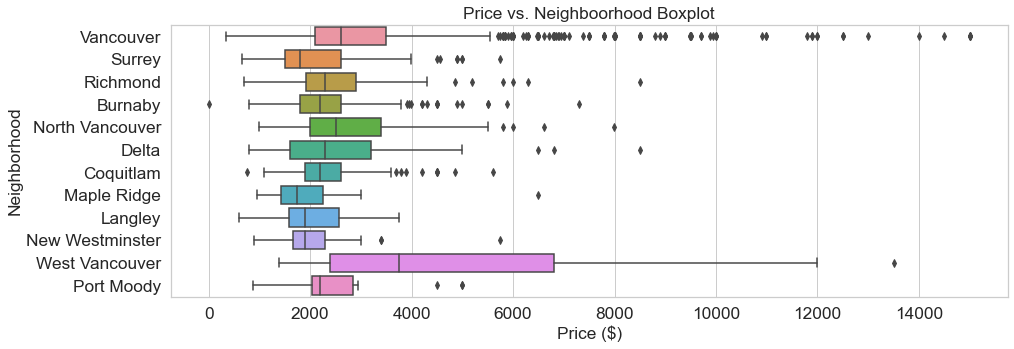

In [72]:
# Remove upper outliers.
upper_limit = van_apts['price'].quantile(0.99)
new_df = van_apts[van_apts['price'] <= upper_limit]

# Box plot
ax = sns.boxplot(x='price', y='neighborhood_simplified', 
                 data=new_df, orient='h')
ax.set_title("Price vs. Neighboorhood Boxplot")
ax.set_ylabel("Neighborhood")
ax.set_xlabel("Price ($)")
plt.show()

Evaluating the scatterplot, we can see West Vancouver generally has the most expensive rental pricing in the Lower Mainland. We can go a step further by getting the mean of each neighborhood group and sorting the results to see the generally most expensive neighboorhoods and least expensive (New Westminster and Surrey).

In [73]:
new_df.groupby('neighborhood_simplified').mean()['price'].sort_values()

neighborhood_simplified
New Westminster    2021.121212
Maple Ridge        2041.739130
Langley            2075.489362
Surrey             2135.543269
Coquitlam          2313.858065
Burnaby            2318.720395
Delta              2504.279070
Richmond           2550.030675
Port Moody         2568.142857
North Vancouver    2838.000000
Vancouver          3146.710404
West Vancouver     4813.965517
Name: price, dtype: float64

Plotting a scatterplot for price against square feet (with hue dictated by number of rooms) we observe a positive coorelation which we expected for more sqft and bedrooms being more expensive.


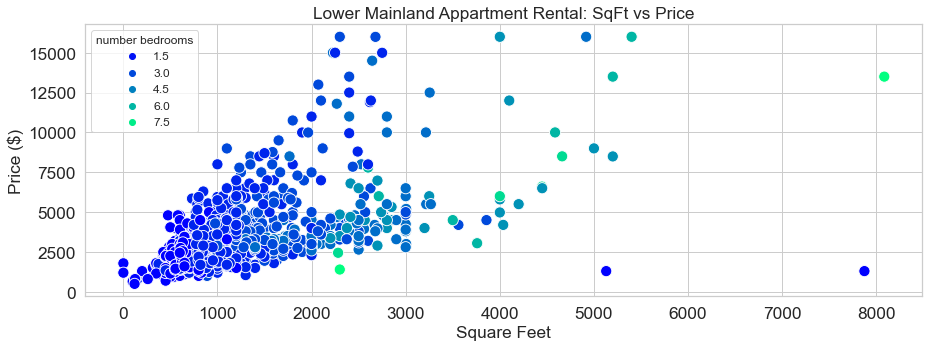

In [45]:
# Scatter Plot: Sqft vs Price
ax = sns.scatterplot(x='sqft', y='price', data=new_df.dropna(), hue='number bedrooms', palette='winter', x_jitter=True, y_jitter=True, s=125)
plt.legend(fontsize=12, title="number bedrooms")
ax.set_title("Price vs. Sqft Scatterplot")
ax.set_xlabel("Square Feet")
ax.set_ylabel("Price ($)")
plt.show()

Our data seems suitable to be modeled using a linear regression model, due to clear positive correlation. As does Riley Predum does here: https://towardsdatascience.com/web-scraping-craigslist-a-complete-tutorial-c41cea4f4981, we can get a regression line with a bootstrap confidence interval. Though I have been exposed to confidence intervals in the past, bootstrap confidence intervals for a linear model is new to me and I may look more into it in the future.

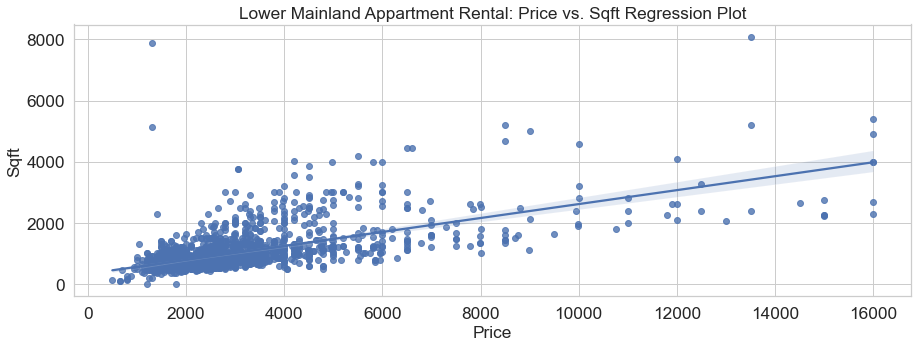

In [25]:
# Regression Plot
sns.regplot(x='price', y='sqft', data=new_df.dropna());
plt.title('Lower Mainland Appartment Rental: Price vs. Sqft Regression Plot');
plt.xlabel("Price");
plt.ylabel("Sqft");

Let's also try to implement our own Linear Regression Model to test how good a linear regression model generalizes on our dataset. We'll do this using the scikit-learn library. Because one of our columns are categorical, we'll need to One-hot encode for our neighborhoods column.

In [74]:
# One-hot encoding
df_one_hot_encoded = pd.get_dummies(new_df, columns=['neighborhood_simplified'])

# Remove columns not needed
df_one_hot_encoded.drop(labels=['neighborhood', 'posted', 'post title', 'URL'], axis=1, inplace=True)
df_one_hot_encoded.dropna(axis=0, how='any', inplace=True)

Index(['number bedrooms', 'sqft', 'price', 'neighborhood_simplified_Burnaby',
       'neighborhood_simplified_Coquitlam', 'neighborhood_simplified_Delta',
       'neighborhood_simplified_Langley',
       'neighborhood_simplified_Maple Ridge',
       'neighborhood_simplified_New Westminster',
       'neighborhood_simplified_North Vancouver',
       'neighborhood_simplified_Port Moody',
       'neighborhood_simplified_Richmond', 'neighborhood_simplified_Surrey',
       'neighborhood_simplified_Vancouver',
       'neighborhood_simplified_West Vancouver'],
      dtype='object')

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# x = df_one_hot_encoded.drop(labels=['price'], axis=1)
x = df_one_hot_encoded.drop(labels=['price', 'number bedrooms'], axis=1)
y = df_one_hot_encoded.loc[:, 'price']

# Split dataset into training and test set.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

print("Start Linear Regression for all Neighborhoods")
# Train and test Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
price_pred = lin_reg.predict(x_test)

# Calculate Mean Absolute Error (MAE)
mae = np.mean([abs(y_actual - y_pred)  for y_actual, y_pred in zip(y_test, price_pred)])
print(f"Mean Absolute Error = {mae}")

Start Linear Regression for all Neighborhoods
Mean Absolute Error = 766.7408376137696


After training and testing our model, we get a Mean Absolute Error of 766.7408376137696. Though there is room to improve our model, which we will discuss below in our final thoughts section, I'm pleased with the results we have gotten. I created a barchart to visualize the frequency for the number of rooms for our dataset.

Final Thoughts
-
I'm happy to have undertaken this little project to apply skills that I've learned in the class and newly learned skills that I can apply in the future. One of biggest surprises that opened my eyes was the idea of Webscrapping for your own dataset. Instead of looking at Kaggle for pre-existing datasets, we can generate our own, from whatever webpages we find on the web(ex: News sites). Additionally, I'm curious about other ways of getting data and transforming our dataset into useful results.

Further work can involve capturing craigslist data over a longer period of time, since craigslist  only keeps 3000 listings at a single time. Additionally, we can improve our model by using different techniques (one technique that I've come across from other similar projects is Principle Component Analysis) and using different models (optimized Random Forest Regression with cross-validation).